<a href="https://colab.research.google.com/github/ntminh981/ApplyParallelProgramming_Group5/blob/main/sequential/PoissonMatting_sequential_improve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisson matting
## Algorithm
1. Initialize alpha, foreground and background values. Alpha = 1 foreground, 0.5 unknown, 0 background. Approximate foreground and background  in unknown region by correspponding nearest known pixel. Smooth the F_B image with Gaussian filter to supress significant changes due to noise and inaccurate estimation.
2. Reconstruct alpha by solving Poisson equation using many iterations of Gauss-Seidel, with overrelaxation.
3. F,B refinement. Set new definite foreground and background based on alpha > 0.95 and alpha < 0.05  respectively. Update unknown F, B using new nearest known F, B pixels and apply another Gaussian filter.

Iterate steps 2,3 untill change in matting results is small or no new Foreground or background pixels are found in step 3.


In [200]:
import os
if not os.path.exists('/content/git'):
  !git clone https://github.com/ntminh981/ApplyParallelProgramming_Group5.git git

Cloning into 'git2'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 38 (delta 4), reused 22 (delta 2), pack-reused 0
Unpacking objects: 100% (38/38), 1.96 MiB | 7.88 MiB/s, done.


In [2]:
from __future__ import division
import numpy as np
import scipy.misc
import scipy.ndimage
import matplotlib.pyplot as plt
import cv2
import time
from numba import jit
import imageio

In [3]:
img = imageio.imread('/content/git/img/troll.png')
gray_img = imageio.imread('/content/git/img/troll.png', as_gray=True)
# trimap = imageio.imread('/content/git/img/generated_trimap.png', as_gray=True)
trimap = imageio.imread('/content/git/img/trollTrimap.bmp', as_gray=True)
# scale = 0.1
# img = scipy.misc.imresize(img, scale)
# gray_img = scipy.misc.imresize(gray_img, scale)
# trimap = scipy.misc.imresize(trimap, scale)
try:
  h, w ,c  = img.shape
except:
  h, w  = img.shape

<ipython-input-3-11f4f9da475a>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/content/git/img/troll.png')
<ipython-input-3-11f4f9da475a>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gray_img = imageio.imread('/content/git/img/troll.png', as_gray=True)
<ipython-input-3-11f4f9da475a>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  trimap = imageio.imread(

In [4]:
fg = trimap == 255
bg = trimap == 0
# fg = trimap > 245
# bg = trimap < 10
unknown = True ^ np.logical_or(fg,bg)
img = img
fg_img = gray_img*fg
bg_img = gray_img*bg
alphaEstimate = fg + 0.5 * unknown

In [7]:
def is_fg(i, j, fg):
  for u in range(i-1, i+2):
    for v in range(j-1, j+2):
      if not fg[u,v]:
        return False
  return True

def get_fg_patch(img, fg):
  patches = []
  for i in range(1, h - 1):
    for j in range(1, w - 1):
        if fg[i, j]:
          if is_fg(i, j, fg):
            patch = img[i - 1:i + 2, j - 1:j + 2, :]
            score = np.sum(np.sqrt(2*((patch[:,:,0]) + 4*((patch[:,:,1])**2) + 3*((patch[:,:,2])**2))))
            color = np.intc(np.mean(patch, axis=(0,1)))
            patches.append({'score':score, 'color':color})
  return patches

fg_patches = get_fg_patch(img, fg)
bg_patches = get_fg_patch(img, bg)
print(len(fg_patches))
print(len(bg_patches))

18260
62897


In [14]:
@jit
def estimateUnknown(img, h, w, unknown_mask, mask, patches):
  approx_img = (mask + unknown_mask).reshape(h,w,1).repeat(3,2) * img
  total = (h-1)*(w-1)
  period = int(total*0.05)
  n=0
  for i in range(1, h - 1):
    for j in range(1, w - 1):
      if unknown_mask[i, j]:
        upatch = img[i - 1:i + 2, j - 1:j + 2, :]
        minDis = 1000000
        minColor = None
        score = np.sum(np.sqrt(2*((upatch[:,:,0]) + 4*((upatch[:,:,1])**2) + 3*((upatch[:,:,2])**2))))
        for patch in patches:
          # dis = int(np.sum(np.sqrt((patch-upatch)**2)))
          # d = sqrt(2*(R1-R2) + 4*(G1-G2) + 3*(B1-B2))
          dis = abs(score - patch['score'])
          if dis<minDis:
            minDis=dis
            minColor = patch['color']

        # s = f'[{i},{j}] {approx_img[i][j]} ->'
        approx_img[i][j][:] = minColor
        # print(s, approx_img[i][j])
      n+=1
      if n%period ==0:
        print(f'{n*100/total}%')
  return approx_img

In [ ]:
estimateUnknown(np.ones((1,1)), 1, 1, [True], [True], bg_patches)

In [ ]:
np.sqrt(2*(img[:,:,0]**2) + 4*(img[:,:,1]**2) + 3*(img[:,:,2]**2)).shape

In [ ]:
img2 = img.copy()
img2 = np.array([[[1,1,1],[1,1,1],[1,1,1]], [[1,1,1],[2,2,1],[1,1,1]], [[1,1,1],[1,1,1],[1,1,1]]])
np.intc(np.mean(img2[0:3, 0:3, :],axis=(1,2)))
# img2.shape

In [16]:
# approx_bg = cv2.inpaint(bg_img.astype(np.uint8),(unknown +fg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*(np.logical_not(fg)).astype(np.float32)
# approx_fg = cv2.inpaint(fg_img.astype(np.uint8),(unknown +bg ).astype(np.uint8)*255,3,cv2.INPAINT_TELEA)*(np.logical_not(bg)).astype(np.float32)

# approx_bg = gray_img*(bg+unknown)
# approx_fg = gray_img*(fg+unknown)

print('approx_bg')
approx_bg = estimateUnknown(img, h, w, unknown, bg, bg_patches)
print('approx_fg')
approx_fg = estimateUnknown(img, h, w, unknown, fg, fg_patches)

approx_bg
4.999960716839119%
9.999921433678239%
14.99988215051736%
19.999842867356477%
24.9998035841956%
29.99976430103472%
34.999725017873835%
39.999685734712955%
44.999646451552074%
49.9996071683912%
54.99956788523032%
59.99952860206944%
64.99948931890856%
69.99945003574767%
74.9994107525868%
79.99937146942591%
84.99933218626504%
89.99929290310415%
94.99925361994327%
approx_fg
4.999960716839119%
9.999921433678239%
14.99988215051736%
19.999842867356477%
24.9998035841956%
29.99976430103472%
34.999725017873835%
39.999685734712955%
44.999646451552074%
49.9996071683912%
54.99956788523032%
59.99952860206944%
64.99948931890856%
69.99945003574767%
74.9994107525868%
79.99937146942591%
84.99933218626504%
89.99929290310415%
94.99925361994327%


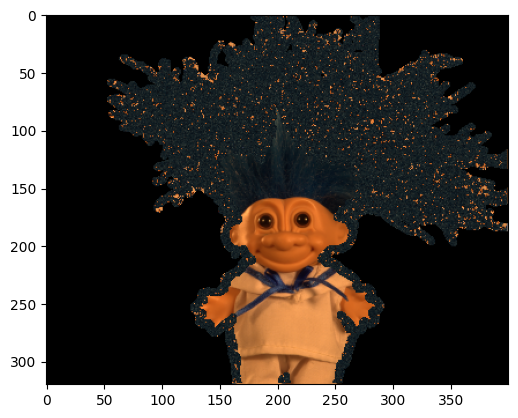

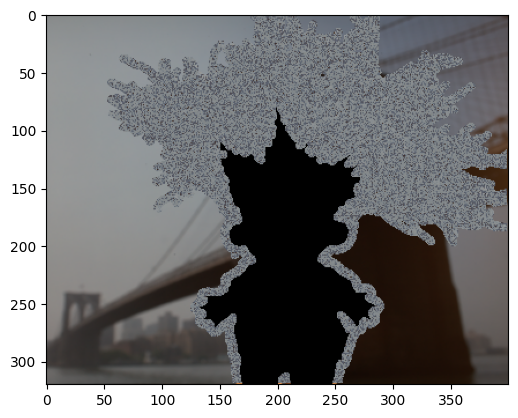

In [17]:
plt.imshow(approx_fg, cmap='gray')
plt.show()
plt.imshow(approx_bg, cmap='gray')
plt.show()

In [159]:
# Smooth F - B image
# approx_diff = np.minimum(np.maximum(approx_fg - approx_bg,0),255)
approx_diff = scipy.ndimage.gaussian_filter(cv2.cvtColor(approx_fg, cv2.COLOR_BGR2GRAY) - cv2.cvtColor(approx_bg, cv2.COLOR_BGR2GRAY), 0.9)
# approx_diff = scipy.ndimage.gaussian_filter(approx_diff, 0.9)
# approx_diff = np.minimum(np.maximum(approx_diff,0),255)
# approx_diff[approx_diff==0] = 1

In [145]:
approx_diff = approx_diff * (fg+unknown)

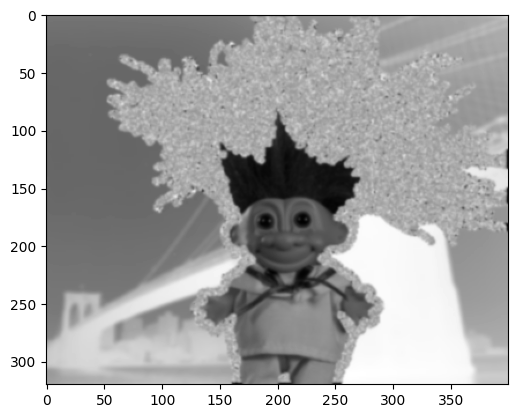

In [160]:
plt.imshow(np.minimum(np.maximum(approx_diff,0),255), cmap='gray')
plt.show()

Poisson Equation

$$\Delta \alpha = div \frac{\nabla I}{F-B}$$

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/9ae5cade73b31dee0e04eb21b1e6e13b5944ef41)

Gauss seidel method

![ig](https://wikimedia.org/api/rest_v1/media/math/render/svg/02f26444f4da61ae84a9824a6b5292949a483fcc)

In [161]:
dy, dx = np.gradient(gray_img)

In [162]:
d2y, _ = np.gradient(dy/approx_diff)
_, d2x = np.gradient(dx/approx_diff)

In [163]:
b = d2y + d2x

In [164]:
def computeAlphaSlow(alpha, b):
    alphaNew = alpha.copy()
    alphaOld = np.zeros(alphaNew.shape)
    threshold = 0.1
    n = 1
    while (n < 50 and np.sum(np.abs(alphaNew - alphaOld)) > threshold):
        alphaOld = alphaNew.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    alphaNew[i,j] = 1/4  * (alphaNew[i-1 ,j] + alphaNew[i,j-1] + alphaOld[i, j+1] + alphaOld[i+1,j] - b[i,j])
        n +=1
    return alphaNew

In [165]:
@jit
def computeAlphaJit(alpha, b):
    alphaNew = alpha.copy()
    alphaOld = np.zeros(alphaNew.shape)
    threshold = 0.1
    n = 1
    while (n < 2000 and np.sum(np.abs(alphaNew - alphaOld)) > threshold):
        alphaOld = alphaNew.copy()
        for i in range(1, h-1):
            for j in range(1, w-1):
                if(unknown[i,j]):
                    alphaNew[i,j] = 1/4  * (alphaNew[i-1 ,j] + alphaNew[i,j-1] + alphaOld[i, j+1] + alphaOld[i+1,j] - b[i,j])
        n +=1
    print("N=",n)
    return alphaNew

In [166]:
def computeAlpha(alpha, b):
    alphaNew = alpha.copy()
    alphaOld = np.zeros(alphaNew.shape)
    threshold = 0.1
    n = 1
    ca = np.transpose(np.nonzero(unknown))
    c = ca[ (ca[:,0]>=1) & (ca[:,0]<h-1) &  (ca[:,1]>=1) & (ca[:,1]<w-1)]
    c0 = c[:,0]
    c1 = c[:,1]
    while (n < 50 and np.sum(np.abs(alphaNew - alphaOld)) > threshold):
        alphaOld = alphaNew.copy()
        alphaNew[c0, c1] = 1/4  * (alphaNew[c0 -1, c1] + alphaNew[c0, c1 -1] + alphaOld[c0,c1+1] + alphaOld[c0+1,c1] - b[c0,c1])
        n +=1
    return alphaNew

In [167]:
# %timeit computeAlphaSlow(alphaEstimate, b)
# %timeit computeAlphaJit(alphaEstimate, b)
# %timeit computeAlpha(alphaEstimate, b)

In [168]:
alpha = computeAlphaJit(alphaEstimate, b)
alpha = np.minimum(np.maximum(alpha,0),1).reshape(h,w)

N= 2000


In [175]:
np.unique(alpha)

array([0.00000000e+00, 2.93406939e-06, 4.38207777e-06, ...,
       9.99950762e-01, 9.99965029e-01, 1.00000000e+00])

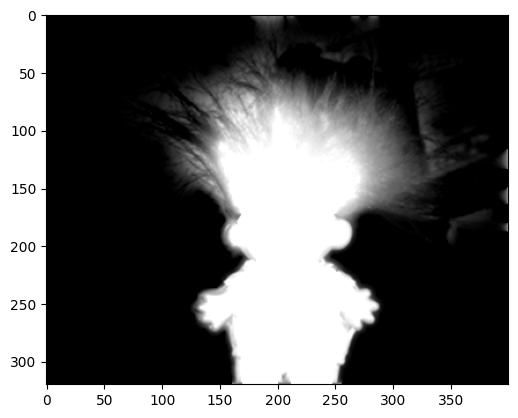

In [169]:
plt.imshow(alpha, cmap='gray')
plt.show()

In [170]:
imageio.imwrite('rollAlpha.png', alpha)

In [171]:
newbg = imageio.imread('/content/git/img/new_bg1.jpg')
newbg = cv2.resize(newbg, (w, h), interpolation=cv2.INTER_LINEAR)
newbg.shape

<ipython-input-171-b344aa352eb7>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  newbg = imageio.imread('/content/git/img/new_bg1.jpg')


(320, 400, 3)

### Replace with new background

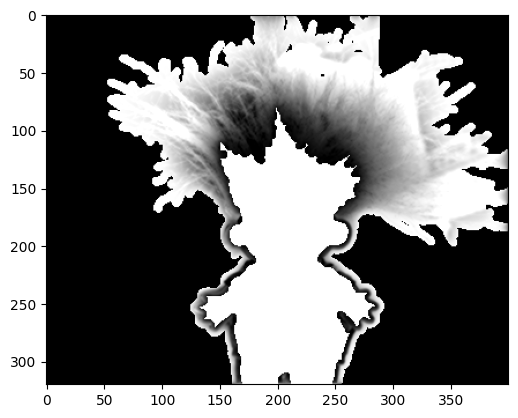

In [193]:
alpha*unknown
plt.imshow(((1-alpha*unknown)*(1-bg)), cmap='gray')

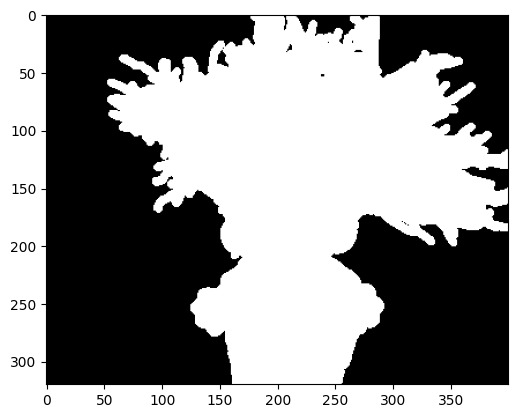

In [194]:
plt.imshow(((1-bg)), cmap='gray')

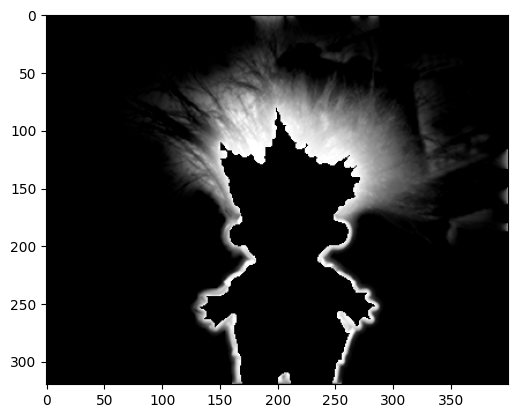

In [197]:
plt.imshow((((alpha)*unknown)), cmap='gray')

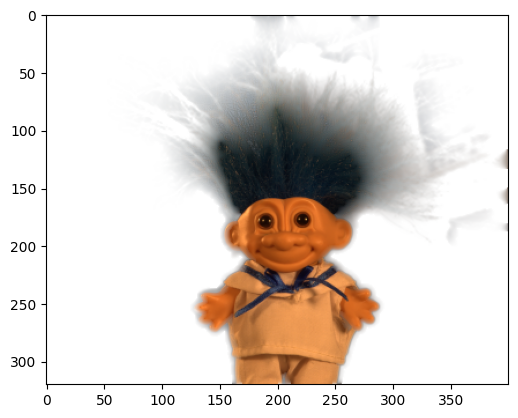

In [172]:
newbg = np.full((h,w,3),255)#imageio.imread('/content/git/img/new_bg1.jpg')
newbg = cv2.resize(newbg, (w, h), interpolation=cv2.INTER_LINEAR)
try:
  plt.imshow((alpha.reshape(h,w,1).repeat(3,2)*img + (1 - alpha.reshape(h, w, 1).repeat(3,2)) * newbg).astype(np.uint8))
except:
  plt.imshow((alpha.reshape(h,w,1).repeat(3,2)*img.reshape(h,w,1) + (1 - alpha.reshape(h, w, 1)) * newbg).astype(np.uint8))
plt.show()